The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [1]:
# Load libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasRegressor



In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
dataset = pd.read_csv('BitstampData.csv')

In [4]:
# shape
dataset.shape

(2841377, 8)

In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700166,3723.784755,2190.247337
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561029,14402.811961,2195.206304
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.662847,34361.023647,2193.791712
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090309,59913.492565,2211.620837
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.961835,21972.308955,2205.648801


In [7]:
# describe data
set_option('display.precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.841e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06
mean,1.411e+09,4.959e+02,4.962e+02,4.955e+02,4.959e+02,1.188e+01,5.316e+03,4.959e+02
std,4.938e+07,3.642e+02,3.645e+02,3.639e+02,3.643e+02,4.094e+01,1.998e+04,3.642e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.368e+09,2.399e+02,2.400e+02,2.398e+02,2.399e+02,3.828e-01,1.240e+02,2.399e+02
50%,1.411e+09,4.200e+02,4.200e+02,4.199e+02,4.200e+02,1.823e+00,6.146e+02,4.200e+02
75%,1.454e+09,6.410e+02,6.417e+02,6.402e+02,6.410e+02,8.028e+00,3.108e+03,6.410e+02
max,1.496e+09,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03


In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [9]:
# Remplace les valeurs Nan par la derniere valeur non Nan
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

# supprime la colonne Timestamp
dataset=dataset.drop(columns=['Timestamp'])


# Préparation des données pour la classification  
Nous attribuons un label à chaque mouvement :  
* **1** si la moyenne mobile à court terme est au-dessus de la moyenne mobile à long terme (signal d'achat).   
* **0** si les deux moyennes mobiles sont égales (signal neutre).  


In [10]:
# Initialiser la colonne `short_mavg` avec la moyenne mobile simple sur une fenêtre courte (10 périodes)
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Initialiser la colonne `long_mavg` avec la moyenne mobile simple sur une fenêtre longue (60 périodes)
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Générer un signal d'achat (1) si la moyenne mobile courte est supérieure à la moyenne mobile longue,
# sinon attribuer un signal neutre (0)
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)



In [11]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0


# Feature engineering
We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [12]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [13]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [14]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2181.37,1.700,2190.247,0.0,2181.181,2182.376,2211.244,0.431,-0.649,8.42,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2195.63,6.561,2195.206,0.0,2183.808,2183.231,2211.088,1.088,-0.062,23.63,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2191.83,15.663,2193.792,0.0,2185.266,2183.786,2210.897,1.035,-0.235,19.83,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2203.51,27.090,2211.621,0.0,2188.583,2185.058,2210.823,1.479,0.297,34.13,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2208.33,9.962,2205.649,1.0,2192.174,2186.560,2210.798,1.626,0.516,36.94,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [15]:
# Data visualisation

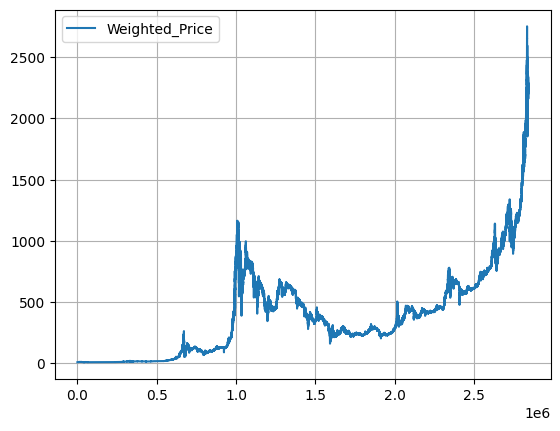

In [16]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

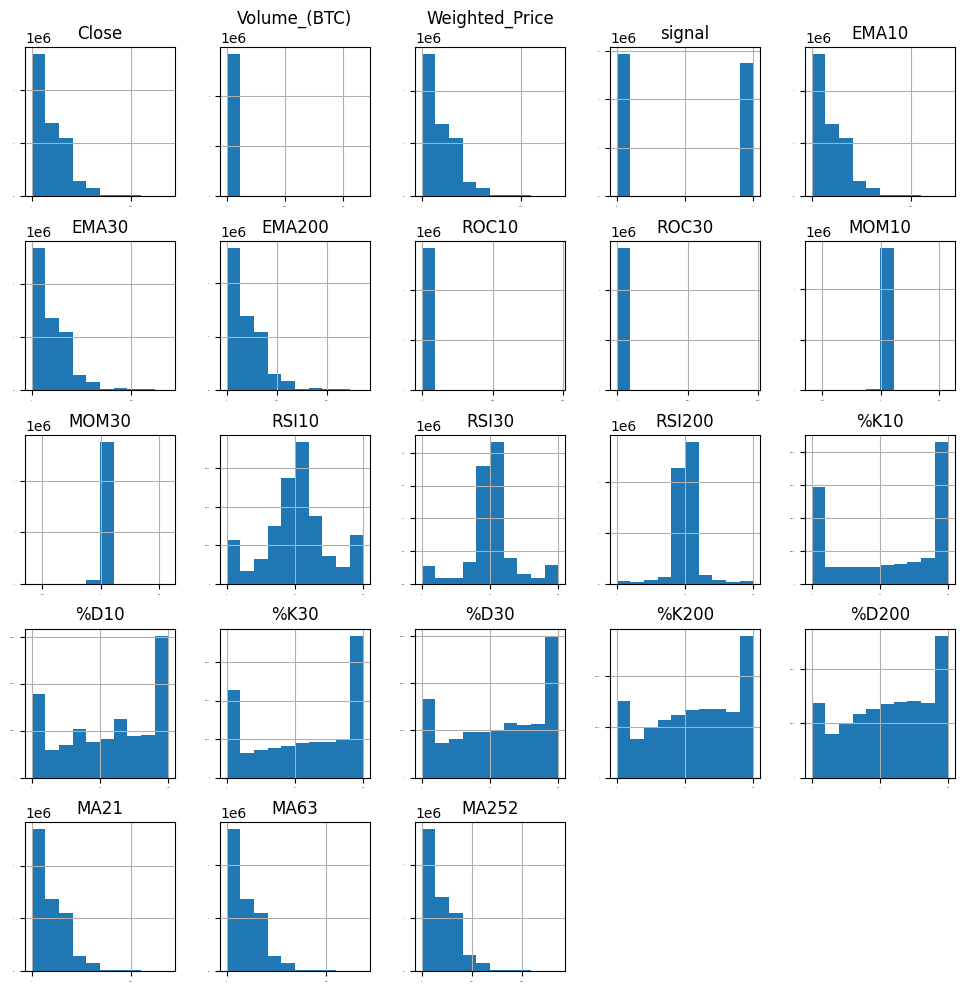

In [17]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

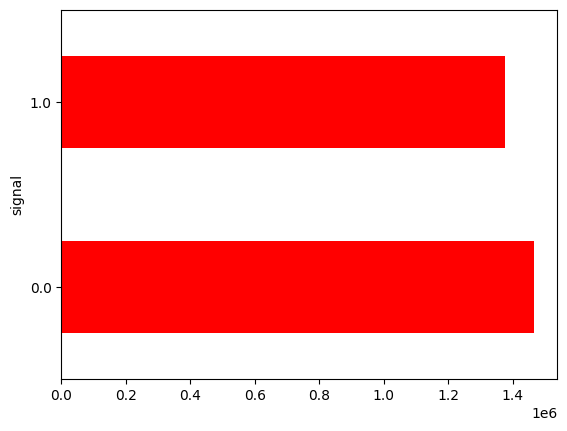

In [18]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()


<Axes: title={'center': 'Correlation Matrix'}>

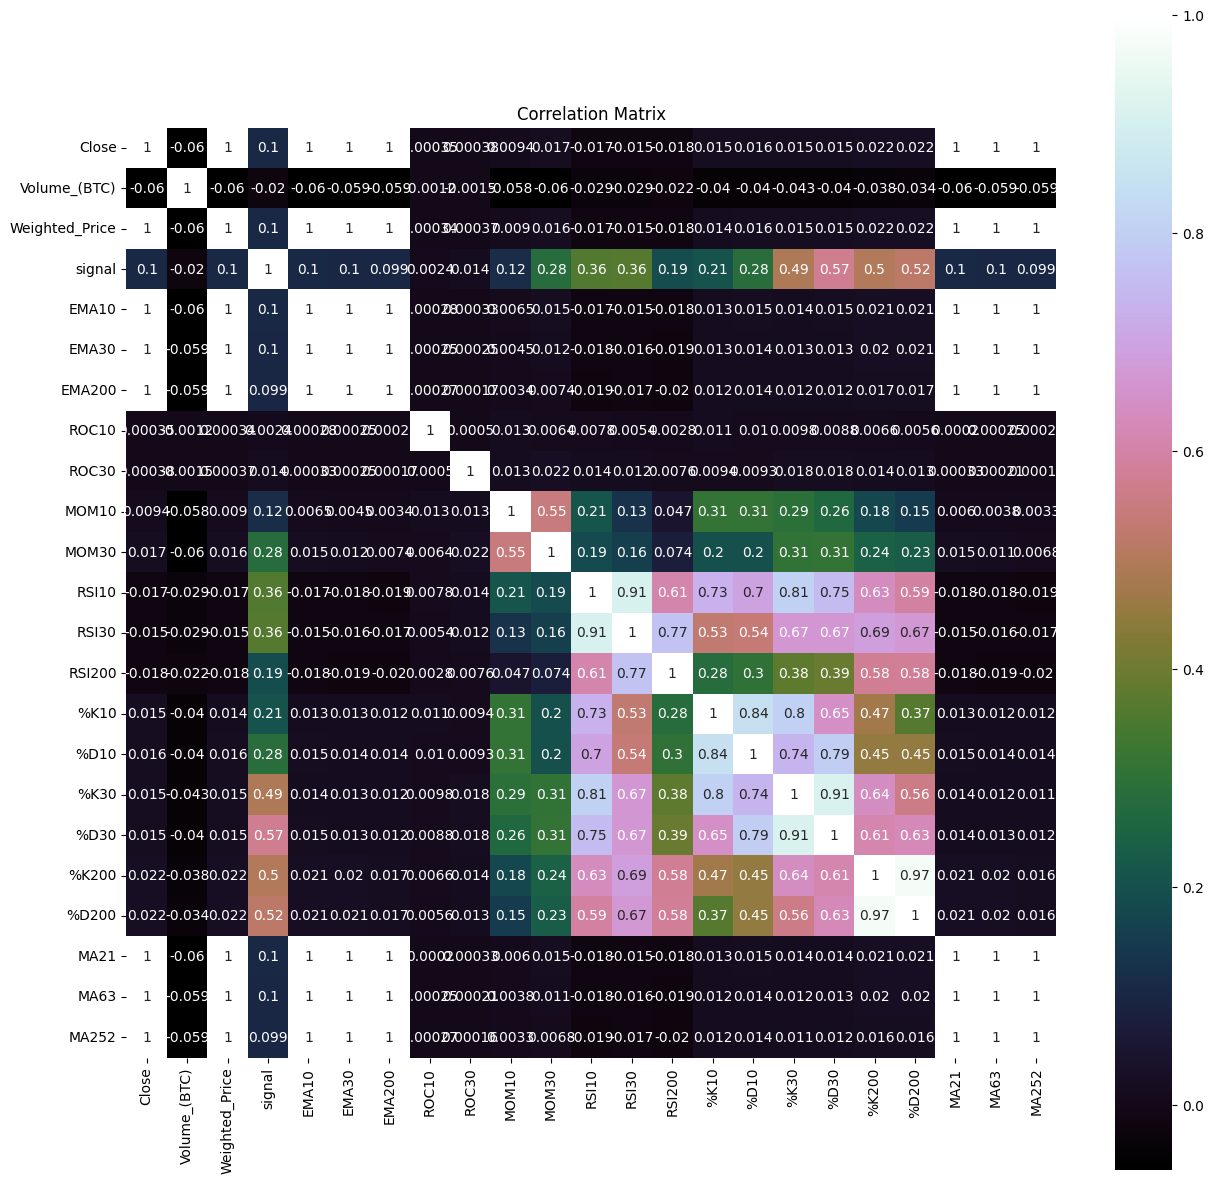

In [19]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# evaluation des algorithme et models

We split the dataset into 80% training set and 20% test set.

In [20]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Data Standardisation
As a preprocessing step, let's start with normalizing the feature values so they standardised - this makes comparisons simpler and allows next steps for Singular Value Decomposition.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,Close,Volume_(BTC),Weighted_Price,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2820066,0.506,0.515,0.502,0.511,0.512,0.533,-0.460,0.240,-0.197,0.341,...,-1.081,-1.108,-1.182,-0.528,-0.376,-1.078,-0.971,0.509,0.515,0.537
2817800,0.790,-0.374,0.790,0.788,0.786,0.784,0.113,0.202,0.104,0.276,...,-0.028,1.210,1.283,1.078,1.043,0.701,0.673,0.787,0.787,0.775


<a id='4.2'></a>
## 5.2. Singular Value Decomposition-(Feature Reduction)

We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible. 

Hence, we use a technique called singu‐
lar value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. We are using the TruncatedSVD method in the sklearn package.

Variance preserved by first 5 components == 90.28%


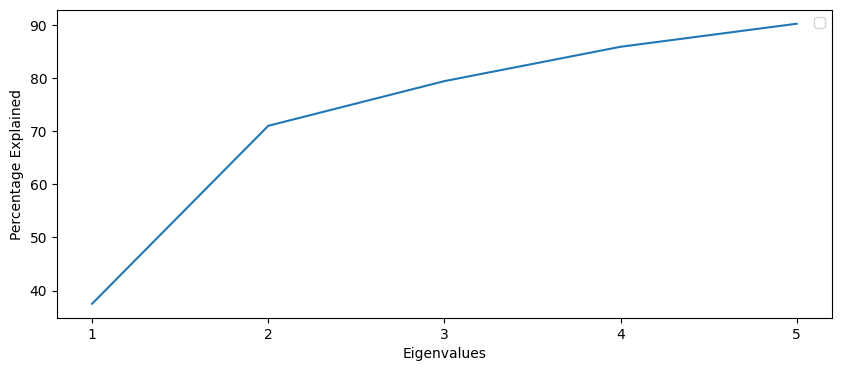

In [23]:
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

We can preserve 90.28% variance by using just 5 components rather than the full 25+ original features.

In [24]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(79773, 5)


,c0,c1,c2,c3,c4
2820066,0.324,-2.354,-0.550,1.203,0.816
2817800,2.950,0.776,-0.390,-1.065,-0.619
2828322,2.527,-3.141,0.691,1.084,-0.576
2798804,-0.306,1.042,-0.437,0.003,-0.005
2775993,0.113,4.113,0.591,-0.696,-0.220



##  Basic Visualisation of Reduced Features
Lets attempt to visualise the data with the compressed dataset, represented by the top 5 components of an SVD.

In [25]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

### Pairs Plots
Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).

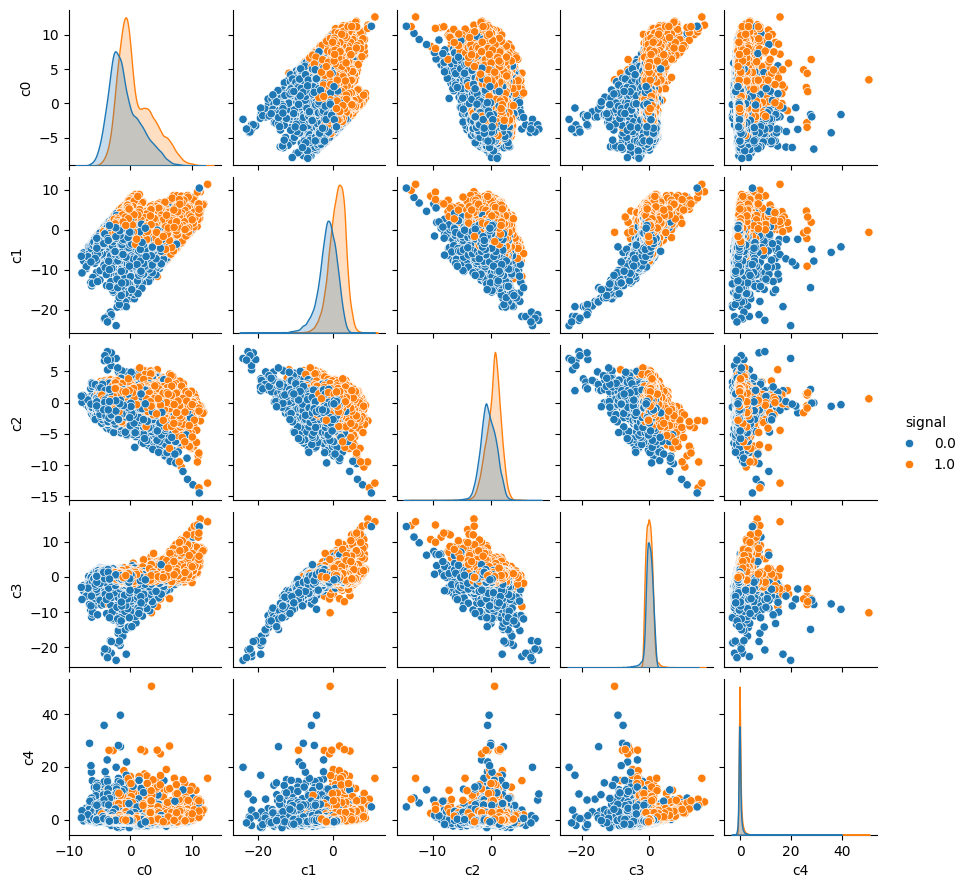

In [26]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

__Observation__:

* In the scatter plot of each of the principal component, we can clearly that there is
a clear segregation of the orange and blue dots, which means that data-points
from the same type of signal tend to cluster together.

* However, it’s hard to get a full appreciation of the differences and similarities
between data points across all the components, requiring that the reader hold
comparisons in their head while viewing

### 3D Scatterplot
As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

In [31]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def scatter_3D(A, elevation=30, azimuth=120):
    # Limiter le nombre de points pour une meilleure performance
    maxpts = 1000
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts, A.shape[0]), replace=False))
    
    # Couleur basée sur la colonne 'signal'
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])

    # Création de la figure avec plotly
    fig = go.Figure(data=[go.Scatter3d(
        x=A.iloc[rndpts, 0], 
        y=A.iloc[rndpts, 1], 
        z=A.iloc[rndpts, 2],
        mode='markers',
        marker=dict(
            size=6,
            color=colors,
            colorscale='Jet',
            opacity=0.6
        )
    )])

    # Mise à jour des paramètres de la vue 3D
    fig.update_layout(
        scene=dict(
            xaxis_title='component 0',
            yaxis_title='component 1',
            zaxis_title='component 2',
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1.25),
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0)
            ),
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        scene_aspectmode="cube"
    )

    fig.show()

# Exemple d'utilisation
import ipywidgets as widgets
from ipywidgets import interactive

dfsvd['signal'] = Y_train

# Utilisation du widget interactif de plotly
interactive_plot = interactive(scatter_3D, A=fixed(dfsvd), elevation=widgets.FloatSlider(value=30, min=0, max=90), azimuth=widgets.FloatSlider(value=120, min=0, max=360))
interactive_plot


interactive(children=(FloatSlider(value=30.0, description='elevation', max=90.0), FloatSlider(value=120.0, des…

__Observation__:

The iPython Notebook interactive package lets us create an interactive plot with controls for elevation and azimuth
We can use these controls to interactively change the view of the top 3 components and investigate their relations. This certainly appears to be more informative than pairs-plots.

However, we still suffer from the same major limitations of the pairs-plots, namely that we lose a lot of the variance and have to hold a lot in our heads when viewing.

## t-SNE visualization
In this step, we implement another technique of dimensionality reduction - t-SNE and look at the related visualization.We will use the basic
implementation available in scikit-learn

In [32]:
tsne = TSNE(n_components=2, random_state=0)

Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

dftsne['signal'] = Y_train

__Observation__:

This is quite interesting way of visualizing the trading signal data. The above plot shows us that there is a good degree of clustering for the trading signal. Although, there are some overap of the long and short signals, but they can be distinguished quite well using the reduced number of features. 

__In Review__:

We have analyzed the bitcoin trading signal dataset in the following steps:

* We prepared the data by cleaning (removing character features values, replacing nans) and normalizing.
* We applied transformation during the feature reduction stage.
* We then visualized the data in the reduced dimentionality and ultimately applied t-SNE algorithm to reduce the data into two dimensions and visualize effectivly

## Compare Models-with and without dimensionality Reduction

In [ ]:
scoring = 'accuracy'
import time
start_time = time.time()


# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=KFold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=KFold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))